# **Adversarial Example Demo: Fooling AI with Altered Inputs**

This notebook demonstrates how adversarial examples can be crafted to exploit vulnerabilities in AI models. We'll train a simple convolutional neural network (CNN) on the MNIST dataset, create an adversarial image using the **Fast Gradient Sign Method (FGSM)**, and observe how the model's predictions are affected.

## **1. Introduction**

**Goal:**
- To demonstrate the concept of adversarial examples using an AI model trained on the MNIST dataset.
- To highlight how small, intentional alterations to an input image can cause misclassification.

**Outline:**
- Load and preprocess the MNIST dataset.
- Train a CNN for digit classification.
- Use FGSM to craft adversarial examples.
- Visualize and analyze the impact of adversarial examples on model predictions.

## **2. Setup and Data Preprocessing**

In [1]:
# Install necessary libraries (if not pre-installed)
!pip install tensorflow matplotlib numpy

# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0  # Scale pixel values to [0, 1]

# Prepare the dataset for the model
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


2025-01-09 10:56:28.084680: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 10:56:28.085111: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 10:56:28.087296: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 10:56:28.093612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736420188.104352    2082 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736420188.10

## **3. Building and Training the Model**

In [2]:
# Build a simple convolutional neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

Epoch 1/3


/usr/local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-09 10:56:31.627274: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9131 - loss: 0.2896 - val_accuracy: 0.9811 - val_loss: 0.0592
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9848 - loss: 0.0519 - val_accuracy: 0.9842 - val_loss: 0.0467
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9901 - loss: 0.0314 - val_accuracy: 0.9873 - val_loss: 0.0405
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9842 - loss: 0.0507 
Model Accuracy: 0.99


## **4. Visualizing the Original Image**

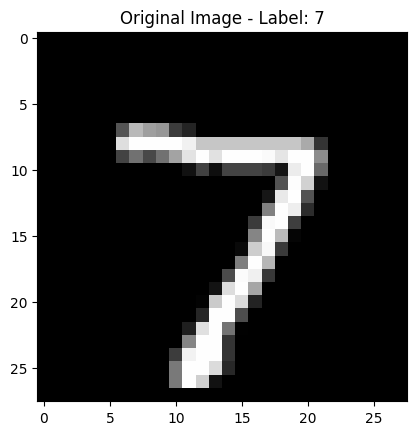

In [3]:
# Select an example from the test set
test_img = x_test[0:1]  # First image
test_label = y_test[0]  # Corresponding label

# Display the original image
plt.title(f"Original Image - Label: {test_label}")
plt.imshow(test_img[0, ..., 0], cmap='gray')
plt.show()

## **5. Crafting the Adversarial Example**

In [4]:
# Define the FGSM method to generate adversarial examples
def create_adversarial_example(model, input_image, true_label, epsilon=0.1):
    input_image = tf.convert_to_tensor(input_image)
    true_label = tf.convert_to_tensor([true_label])

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(true_label, prediction)

    # Compute the gradients of the loss w.r.t. the input image
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)

    # Create the adversarial example
    adversarial_image = input_image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image

# Generate the adversarial example
epsilon = 0.2  # Perturbation factor
adversarial_img = create_adversarial_example(model, test_img, test_label, epsilon)

## **6. Visualizing the Adversarial Image**

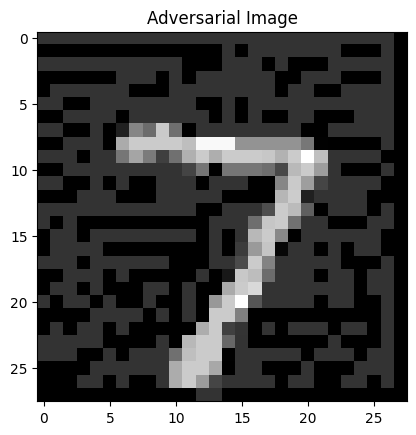

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Original Label: 7
Adversarial Prediction: 7


In [5]:
# Display the adversarial image
plt.title("Adversarial Image")
plt.imshow(adversarial_img[0, ..., 0], cmap='gray')
plt.show()

# Test the model's prediction on the adversarial image
adversarial_prediction = model.predict(adversarial_img)
adversarial_label = np.argmax(adversarial_prediction)

print(f"Original Label: {test_label}")
print(f"Adversarial Prediction: {adversarial_label}")

## **7. Analysis and Discussion**
- **Visualization**:
  - The original image is correctly classified by the model.
  - The adversarial image contains minimal noise but causes the model to misclassify.
- **Key Insight**:
  - Adversarial examples exploit vulnerabilities in AI systems by introducing small, imperceptible perturbations.
  - This demonstrates the need for robust AI models to handle adversarial attacks.

## **8. Quiz Questions**
1. **What is the primary goal of generating an adversarial example?**
   - A. To improve model accuracy
   - B. To test the robustness of AI models against small, intentional perturbations
   - C. To visualize dataset distributions
   **Answer:** B

2. **Which parameter in the FGSM method controls the strength of the perturbation?**
   - A. Learning rate
   - B. Loss function
   - C. Epsilon
   **Answer:** C

3. **What happens if the value of epsilon is too large in the adversarial example generation?**
   - A. The adversarial image becomes indistinguishable from the original.
   - B. The adversarial image may look unrealistic and not represent the original input.
   - C. The model's accuracy increases.
   **Answer:** B

## 
**9. Conclusion**
Congratulations! You have successfully:
- Trained a CNN on the MNIST dataset.
- Created adversarial examples using FGSM.
- Observed how small perturbations can cause AI models to misclassify.

This exercise highlights the importance of adversarial robustness in developing secure and reliable AI systems.